# Comparison of dgemm calibrations w.r.t. how the matrices are generated

In these experiments, we perform calls to dgemm with three square matrices of order 2,048.

We will look at dgemm performance and the node temperatures and frequencies for different matrix generation methods. Each element of the matrix is set to some random number between 0 and 1. Then, we apply a mask to set its N lowest order bits to 1.

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    df['index'] = range(len(df))
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

c0a430e3a498fc690b6244ca9909444040c28128


In [2]:
import numpy

directories = ['matrix_generation/pyxis/2/']

def get_monitoring(archive_name, csv_name, min_start=None, max_stop=None):
    df = read_csv(archive_name, csv_name)
    for col in ['start', 'stop']:
        df[col] = pandas.to_datetime(df[col])
    first = df['start'].min()
    df['start'] -= first
    df['stop'] -= first
    if min_start is not None:
        old_len = len(df)
        df = df[df['start'] >= pandas.to_timedelta(min_start, unit='s')]
#        print('Archive %s: removed %d entries that happened before time %.2f s' % (archive_name, old_len-len(df), min_start))
    if max_stop is not None:
        old_len = len(df)
        df = df[df['stop'] <= pandas.to_timedelta(max_stop, unit='s')]
#        print('Archive %s: removed %d entries that happened after time %.2f s' % (archive_name, old_len-len(df), max_stop))
    if min_start is not None:
        first = df['start'].min()
        df['start'] -= first
        df['stop'] -= first
    return df

def my_read_monitoring(archive_name, columns=None):
    '''
    Custom implementation of read_monitoring, to *not* read the temperature, as it is not available for Pyxis cluster.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    core_mapping = ae.platform_to_cpu_mapping(ae.get_platform(archive_name))
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    frequency   = ae.my_melt(df, 'frequency_core_', columns)
    # removing the cores with unknown IDs (they are not real cores, just hyperthreads)
    frequency = frequency[frequency['group'].isin(core_mapping)]
    for frame, val in [(frequency, 'frequency')]:
        frame['value'] = frame[f'{val}_core_']
        frame.drop(f'{val}_core_', axis=1, inplace=True)
        frame['cpu'] = frame.apply(lambda row: core_mapping[row['group']], axis=1)
        frame['core'] = frame['group']
        frame.drop('group', axis=1, inplace=True)
        frame['kind'] = val
    frequency['value'] *= 1e-9  # Hz → GHz
    df = pandas.concat([frequency])
    info = ae.read_yaml(archive_name, 'info.yaml')
    timestamps = info['timestamp']
    for step in ['start', 'stop']:
        df[f'{step}_exp'] = pandas.to_datetime(timestamps['run_exp'][step]).timestamp()
    df['timestamp'] = df['timestamp'].astype(numpy.int64) / 10 ** 9
    return df


def read_archive(archive_name):
    df = read_csv(archive_name, 'result.csv')
    df['start'] = df['timestamp']
    df['end'] = df['start'] + df['duration']
    df['mnk'] = df['m'] * df['n'] * df['k']
    df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
    core_mapping = ae.platform_to_cpu_mapping(ae.get_platform(archive_name))
    df['cpu'] = df.apply(lambda row: core_mapping[row.core], axis=1)
    info = get_yaml(archive_name, 'info.yaml')
    installfile = info['installfile']
    matrix_init = get_yaml(archive_name, installfile)['matrix_initialization']
    try:
        mask_size = get_yaml(archive_name, installfile)['matrix_initialization_mask_size']
    except KeyError:
        mask_size = 0
    hosts = [key for key in info.keys() if key.endswith('grid5000.fr')]
    assert len(hosts) == 1
    host = hosts[0]
    host = host[:-len('@lyon.grid5000.fr')]
    start_time = df['start'].min()
    stop_time = df['end'].max()
    df['start'] -= start_time
    df['start'] = pandas.to_timedelta(df['start'], unit='s')
    df['end'] -= start_time
    monitoring = my_read_monitoring(archive_name)
    monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
    for date in monitoring['date'].unique():
        monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
    monitoring['start_exp'] -= monitoring['real_start_time']
    monitoring['stop_exp'] -= monitoring['real_start_time']
    monitoring['timestamp'] -= monitoring['real_start_time']
    monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
    for tmp in [df, monitoring]:
        tmp['matrix_content'] = matrix_init
        tmp['mask_size'] = mask_size
        tmp['host'] = host
    return df, monitoring

dataframes = []
cluster = set()
for directory in directories:
    for filename in os.listdir(directory):
        if not filename.endswith('.zip'):
            continue
        path = os.path.join(directory, filename)
        cluster.add(get_yaml(path, 'info.yaml')['cluster'])
        dataframes.append(read_archive(path))
assert len(cluster) == 1
cluster = cluster.pop()

#node = 'dahu-1'
#cpu = 0

performance = pandas.concat([t[0] for t in dataframes])
#performance = performance[(performance['host'] == node) & (performance['cpu'] == cpu)]
monitoring   = pandas.concat([t[1] for t in dataframes])
#frequency   = frequency[(frequency['host'] == node) & (frequency['cpu'] == cpu)]

#performance = performance[performance['matrix_content'] == 'random']
#frequency = frequency[frequency['matrix_content'] == 'random']

performance.head()

,function,m,n,k,lda,ldb,ldc,timestamp,duration,core,...,jobid,index,start,end,mnk,gflops,cpu,matrix_content,mask_size,host
0,dgemm,2048,2048,2048,2048,2048,2048,612.734538,1.275420,0,...,1153395,0,0 days 00:00:06.736324,8.011744,8589934592,13.469970,0,random,30,pyxis-1
1,dgemm,2048,2048,2048,2048,2048,2048,614.010020,1.248877,0,...,1153395,1,0 days 00:00:08.011806,9.260683,8589934592,13.756254,0,random,30,pyxis-1
2,dgemm,2048,2048,2048,2048,2048,2048,615.258911,1.224300,0,...,1153395,2,0 days 00:00:09.260697,10.484997,8589934592,14.032402,0,random,30,pyxis-1
3,dgemm,2048,2048,2048,2048,2048,2048,616.483226,1.208423,0,...,1153395,3,0 days 00:00:10.485012,11.693435,8589934592,14.216768,0,random,30,pyxis-1
4,dgemm,2048,2048,2048,2048,2048,2048,617.691662,1.242423,0,...,1153395,4,0 days 00:00:11.693448,12.935871,8589934592,13.827713,0,random,30,pyxis-1


In [3]:
monitoring.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,date,real_start_time,cpu_id,matrix_content,mask_size,host
0,0.000000,pyxis,1,1153395,1605033149,5d2b89905897c0a2d0141207fc475bf972b2ca3ccb5f41...,2.501487,0,0,frequency,657.067575,2647.30125,2020-11-10 18:32:29,1.605038e+09,1:0,random,30,pyxis-1
1,1.001028,pyxis,1,1153395,1605033149,5d2b89905897c0a2d0141207fc475bf972b2ca3ccb5f41...,2.501487,0,0,frequency,657.067575,2647.30125,2020-11-10 18:32:29,1.605038e+09,1:0,random,30,pyxis-1
2,2.002062,pyxis,1,1153395,1605033149,5d2b89905897c0a2d0141207fc475bf972b2ca3ccb5f41...,2.501487,0,0,frequency,657.067575,2647.30125,2020-11-10 18:32:29,1.605038e+09,1:0,random,30,pyxis-1
3,3.003098,pyxis,1,1153395,1605033149,5d2b89905897c0a2d0141207fc475bf972b2ca3ccb5f41...,2.501487,0,0,frequency,657.067575,2647.30125,2020-11-10 18:32:29,1.605038e+09,1:0,random,30,pyxis-1
4,4.004132,pyxis,1,1153395,1605033149,5d2b89905897c0a2d0141207fc475bf972b2ca3ccb5f41...,2.501487,0,0,frequency,657.067575,2647.30125,2020-11-10 18:32:29,1.605038e+09,1:0,random,30,pyxis-1


## Performance

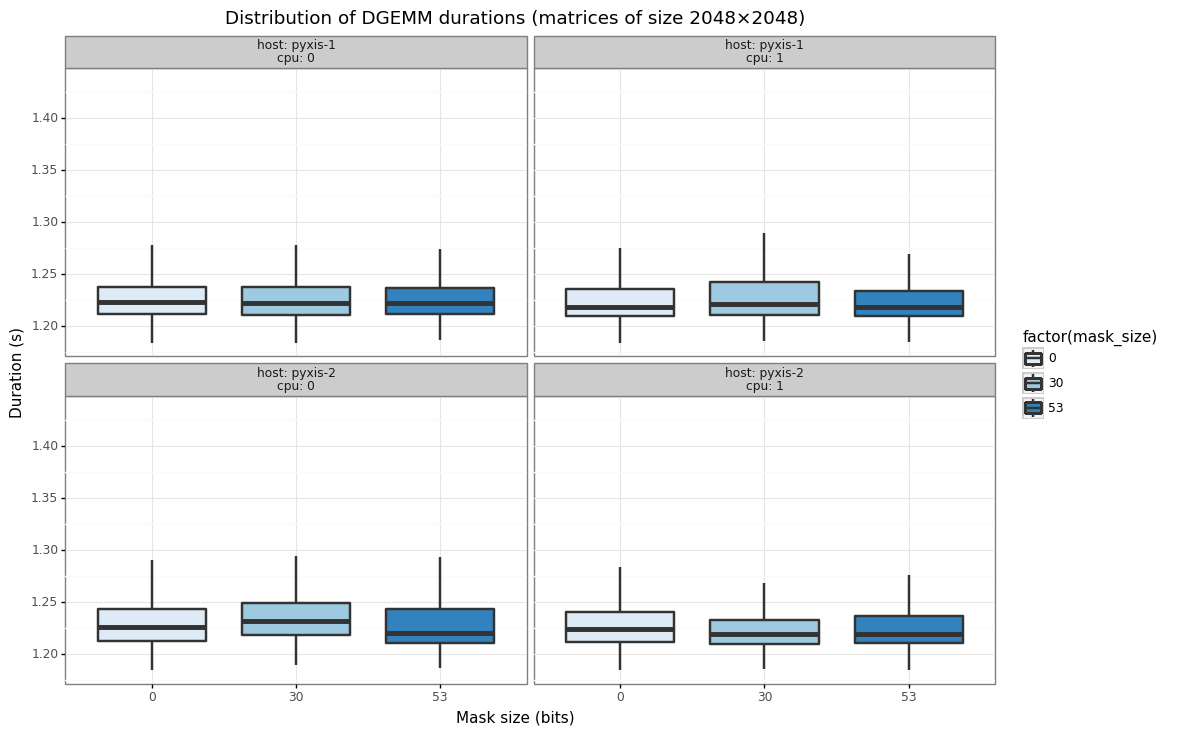

<ggplot: (-9223363298865844725)>

In [4]:
(ggplot(performance)
    + aes(x='factor(mask_size)', y='duration', fill='factor(mask_size)')
    + theme_bw()
    + geom_boxplot(outlier_alpha=0, size=1)
    + xlab('Mask size (bits)')
    + ylab('Duration (s)')
    + labs(color='Mask size (bits)')
    + scale_fill_brewer(palette='Blues')
    + ggtitle('Distribution of DGEMM durations (matrices of size 2048×2048)')
    + facet_wrap(['host', 'cpu'], labeller='label_both')
)

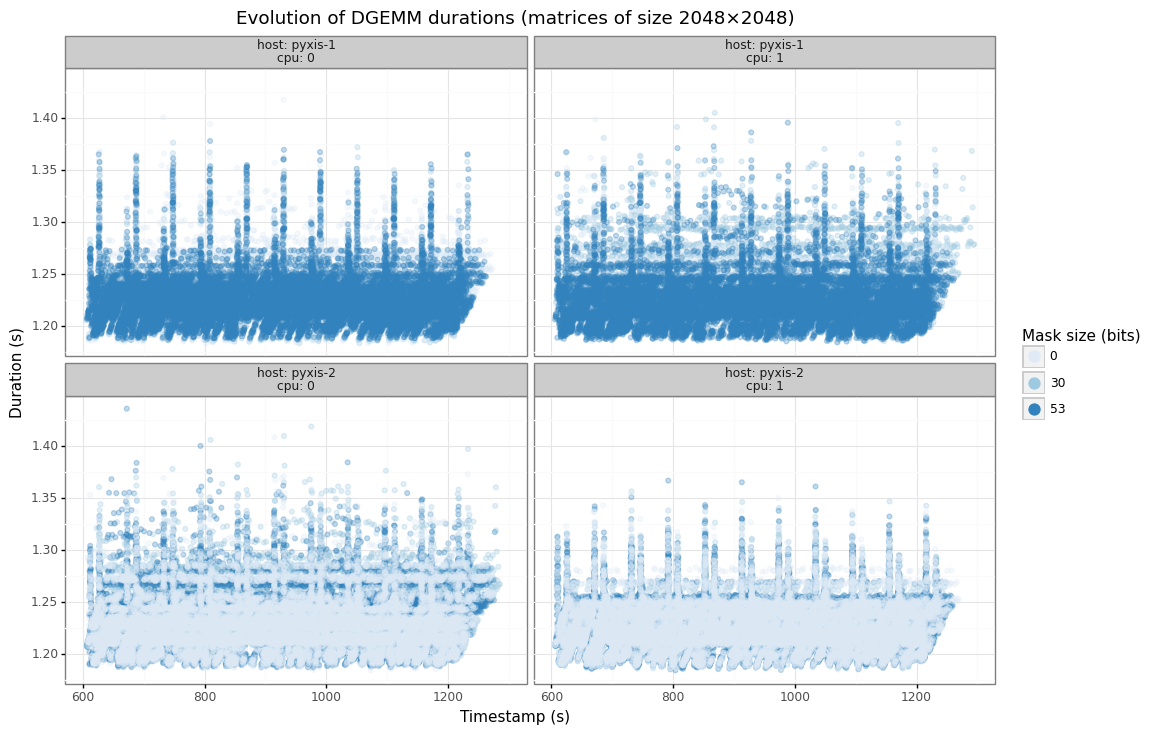

<ggplot: (8737979012360)>

In [5]:
(ggplot(performance)
    + aes(x='timestamp', y='duration', color='factor(mask_size)')
    + theme_bw()
    + geom_point(alpha=0.3)
    + xlab('Timestamp (s)')
    + ylab('Duration (s)')
    + labs(color='Mask size (bits)')
    + scale_color_brewer(palette='Blues')
    + ggtitle('Evolution of DGEMM durations (matrices of size 2048×2048)')
    + facet_wrap(['host', 'cpu'], labeller='label_both')
    + guides(color=guide_legend(override_aes={'alpha': 1, 'size': 4}))
)

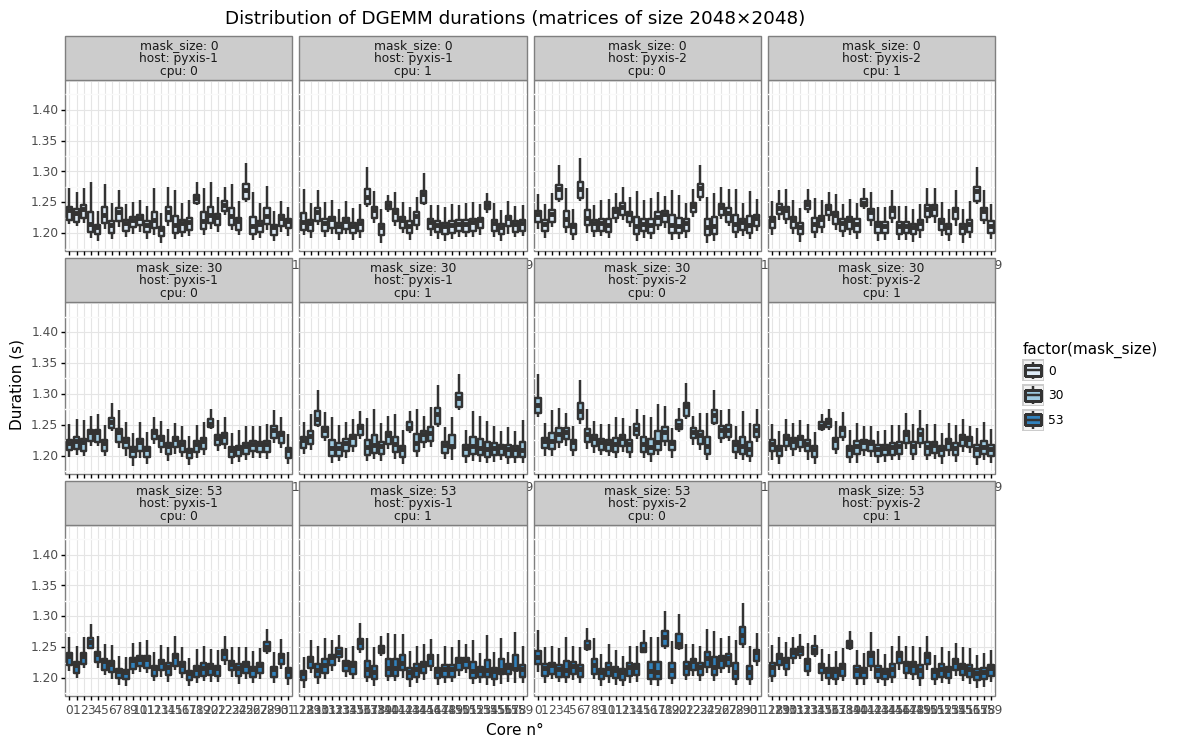

<ggplot: (-9223363298893728645)>

In [6]:
(ggplot(performance)
    + aes(x='factor(core)', y='duration', fill='factor(mask_size)')
    + theme_bw()
    + geom_boxplot(outlier_alpha=0, size=1)
    + xlab('Core n°')
    + ylab('Duration (s)')
    + labs(color='Mask size (bits)')
    + scale_fill_brewer(palette='Blues')
    + ggtitle('Distribution of DGEMM durations (matrices of size 2048×2048)')
    + facet_wrap(['mask_size', 'host', 'cpu'], labeller='label_both', scales='free_x')
)

## Frequency

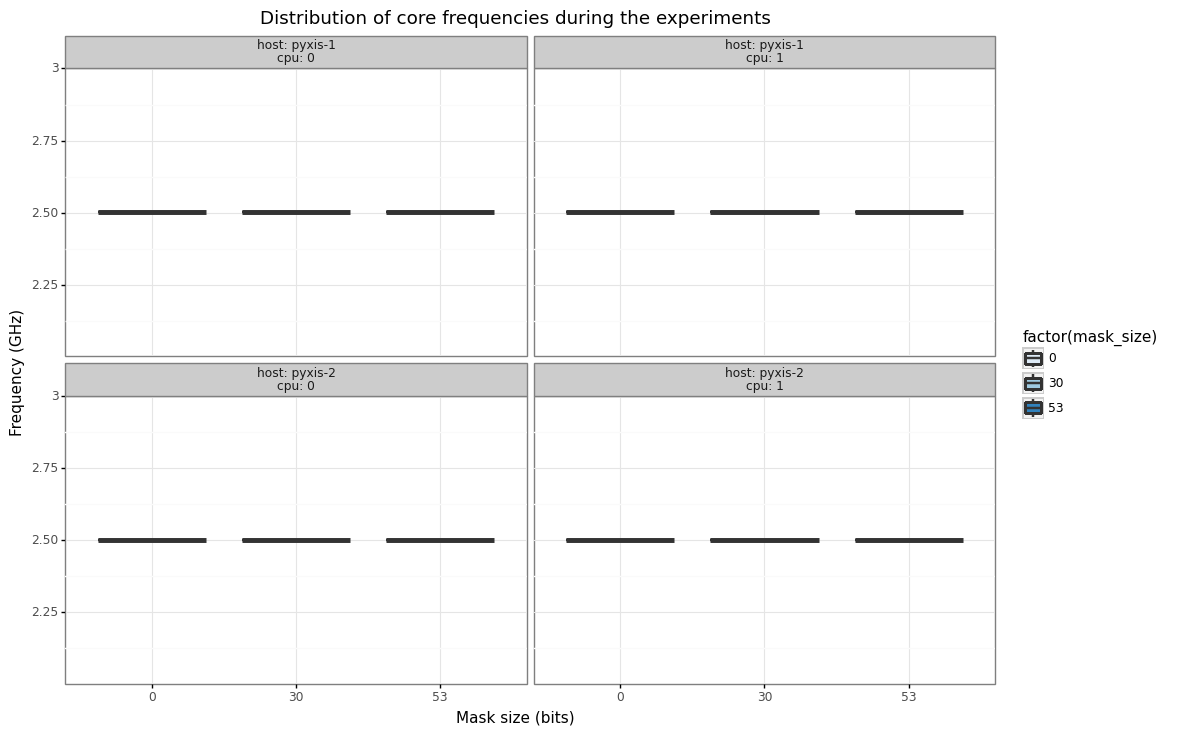

<ggplot: (8737961049394)>

In [7]:
(ggplot(monitoring[(monitoring['kind'] == 'frequency') & (monitoring['timestamp'] > monitoring['start_exp'] + 10) & (monitoring['timestamp'] < monitoring['stop_exp'] - 200)])
    + aes(x='factor(mask_size)', y='value', fill='factor(mask_size)')
    + theme_bw()
    + geom_boxplot(outlier_alpha=0, size=1)
    + xlab('Mask size (bits)')
    + ylab('Frequency (GHz)')
    + labs(color='Mask size (bits)')
    + scale_fill_brewer(palette='Blues')
    + ggtitle('Distribution of core frequencies during the experiments')
    + facet_wrap(['host', 'cpu'], labeller='label_both')
)

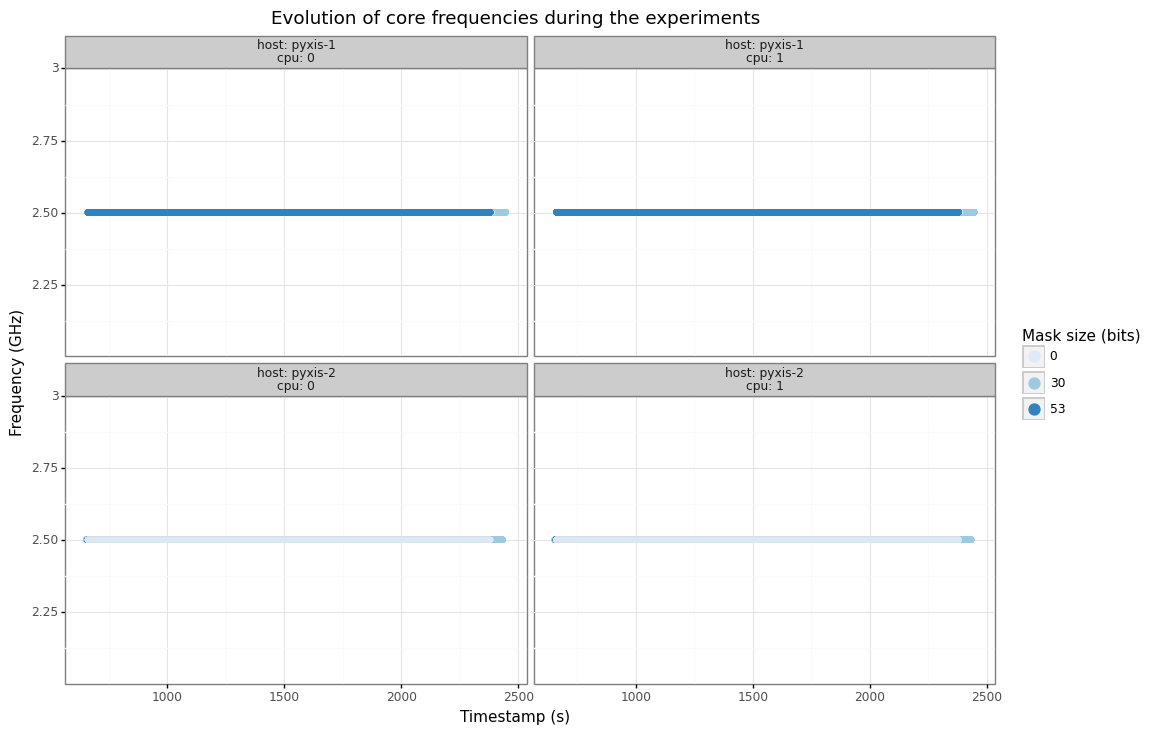

<ggplot: (-9223363298891178394)>

In [8]:
(ggplot(monitoring[(monitoring['kind'] == 'frequency') & (monitoring['timestamp'] > monitoring['start_exp'] + 10) & (monitoring['timestamp'] < monitoring['stop_exp'] - 200)])
    + aes(x='timestamp', y='value', color='factor(mask_size)')
    + theme_bw()
    + geom_point(alpha=0.3)
    + xlab('Timestamp (s)')
    + ylab('Frequency (GHz)')
    + labs(color='Mask size (bits)')
    + scale_color_brewer(palette='Blues')
    + ggtitle('Evolution of core frequencies during the experiments')
    + facet_wrap(['host', 'cpu'], labeller='label_both')
    + guides(color=guide_legend(override_aes={'alpha': 1, 'size': 4}))
)